### Import Required Libraries

In [1]:
# Base libraries
import numpy as np
import pandas as pd
from typing import Tuple
from scipy.stats import norm

# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate

### Black Scholes Formula
The Black–Scholes equation describes the price of the option over time as

$$
\frac{\partial V}{\partial t}
+ \frac 1{2}{\sigma^2 S^2} \frac{\partial^2 V}{\partial S^2}
+ r S \frac{\partial V}{\partial S} - rV = 0 
$$

<br>Solving the above equation, we know that the value of a call option for a non-dividend paying stock is:<br>

$$ C = SN(d_1) - Ke^{-rt}N(d_2) $$

and, the corresponding put option price is:

$$ P = Ke^{-rt}N(-d_2) - SN(-d_1)$$

where, 

$$ d_1= \frac{1}{\sigma \sqrt{t}}\left[\ln{\left(\frac{S}{K}\right)} +{\left(r + \frac{\sigma^2}{2}\right)}t\right] $$
<br>

$$ d_2= d_1 - \sigma \sqrt{t} $$
<br>

$$ N(x)=\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} \mathrm e^{-\frac{1}{2}x^2} dx $$


$S$ is the spot price of the underlying asset<br>
$K$ is the strike price<br>
$r$ is the annualized continuous compounded risk free rate<br>
$\sigma$ is the volatility of returns of the underlying asset<br>
$t$ is time to maturity (expressed in years)<br>
$N(x)$ is the standard normal cumulative distribution

### Greeks

| **Description** |  | **Greeks for Call Option** | **Greeks for Put Option**             
|:-----------|:----------------|:----------------|:--------                                                                                                       
| **Delta**  |$ \space\space \frac {\partial V}{\partial S}$ Sensitivity of Value to changes in price | $N(d_1)$ | $-N(-d_1)$
| **Gamma**  |$ \space\space \frac {\partial ^{2}V}{\partial S^{2}}$ Sensitivity of Delta to changes in price | $\frac{N'(d_1)}{S\sigma\sqrt{t}}$
| **Vega**   |$ \space\space \frac {\partial V}{\partial \sigma}$ Sensitivity of Value to changes in volatility | $SN'(d_1)\sqrt{t}$
| **Theta**  |$ \space\space \frac {\partial V}{\partial t}$ Sensitivity of Value to changes in time | $-\frac{SN'(d_1)\sigma}{2\sqrt{t}}-rKe^{-rt}N(d_2)$ | $-\frac{SN'(d_1)\sigma}{2\sqrt{t}}+rKe^{-rt}N(-d_2)$
| **Rho**    |$ \space\space \frac {\partial V}{\partial r}$  Sensitivity of Value to changes in risk-free | $Kte^{-rt}N(d_2)$ | $-Kte^{-rt}N(-d_2)$

In [2]:
class BS: #create Black Sholes object
    def __init__(self, spot, strike, rate, dte, volatility):
        self.S = spot
        self.K = strike
        self.r = rate
        self.t = dte
        self.sigma = volatility
        
        # Calculate common terms used across methods
        self.time_sqrt = np.sqrt(self.t)
        self.discount_factor = np.exp(-self.r * self.t)
       
        # Calculate d1 and d2 parameters
        self.d1 = self._calculate_d1()
        self.d2 = self.d1 - self.sigma * self.time_sqrt
        
        # Calculate all option Greeks and prices
        self.call_price, self.put_price = self._price()
        self.call_delta, self.put_delta = self._delta()
        self.gamma = self._gamma()
        self.vega = self._vega()
        self.call_theta, self.put_theta = self._theta()
        self.call_rho, self.put_rho = self._rho()
       
    def _calculate_d1(self) -> float:
        return (np.log(self.S / self.K) + (self.r + (self.sigma**2) / 2) * self.t) / (
            self.sigma * self.time_sqrt
        )
    
    def _price(self) -> Tuple[float, float]:
        d1_cdf = norm.cdf(self.d1)
        d2_cdf = norm.cdf(self.d2)

        call = self.S * d1_cdf - self.K * self.discount_factor * d2_cdf
        put = self.K * self.discount_factor * norm.cdf(-self.d2) - self.S * norm.cdf(
            -self.d1
        )
        return call, put
    
    def _delta(self) -> Tuple[float, float]:
        d1_cdf = norm.cdf(self.d1)
        return d1_cdf, -norm.cdf(-self.d1)
    
    def _gamma(self) -> float:
        return norm.pdf(self.d1) / (self.S * self.sigma * self.time_sqrt)
    
    def _vega(self) -> float:
        return self.S * norm.pdf(self.d1) * self.time_sqrt / 100
    
    def _theta(self) -> Tuple[float, float]:
        spot_term = -self.S * norm.pdf(self.d1) * self.sigma / (2 * self.time_sqrt)
        call_rate_term = -self.r * self.K * self.discount_factor * norm.cdf(self.d2)
        put_rate_term = self.r * self.K * self.discount_factor * norm.cdf(-self.d2)

        return (spot_term + call_rate_term) / 365, (spot_term + put_rate_term) / 365
    
    def _rho(self) -> Tuple[float, float]:
        call = self.K * self.t * self.discount_factor * norm.cdf(self.d2) / 100
        put = -self.K * self.t * self.discount_factor * norm.cdf(-self.d2) / 100
        return call, put

### Construct a Black Sholes object with a test set of data

In [3]:
# Initialize option
option = BS(100,100,0.05,1,0.2)

header = ['Type', 'Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [
    [
        'Call',
        option.call_price,
        option.call_delta,
        option.gamma,
        option.call_theta,
        option.vega,
        option.call_rho
    ],
    [   
        'Put',
        option.put_price,
        option.put_delta,
        option.gamma,
        option.put_theta,
        option.vega,        
        option.put_rho       
    ],
]

print(tabulate(table,header))

Type      Option Price      Delta     Gamma        Theta     Vega        Rho
------  --------------  ---------  --------  -----------  -------  ---------
Call          10.4506    0.636831  0.018762  -0.0175727   0.37524   0.532325
Put            5.57353  -0.363169  0.018762  -0.00454214  0.37524  -0.418905


### Visualize the Payoff

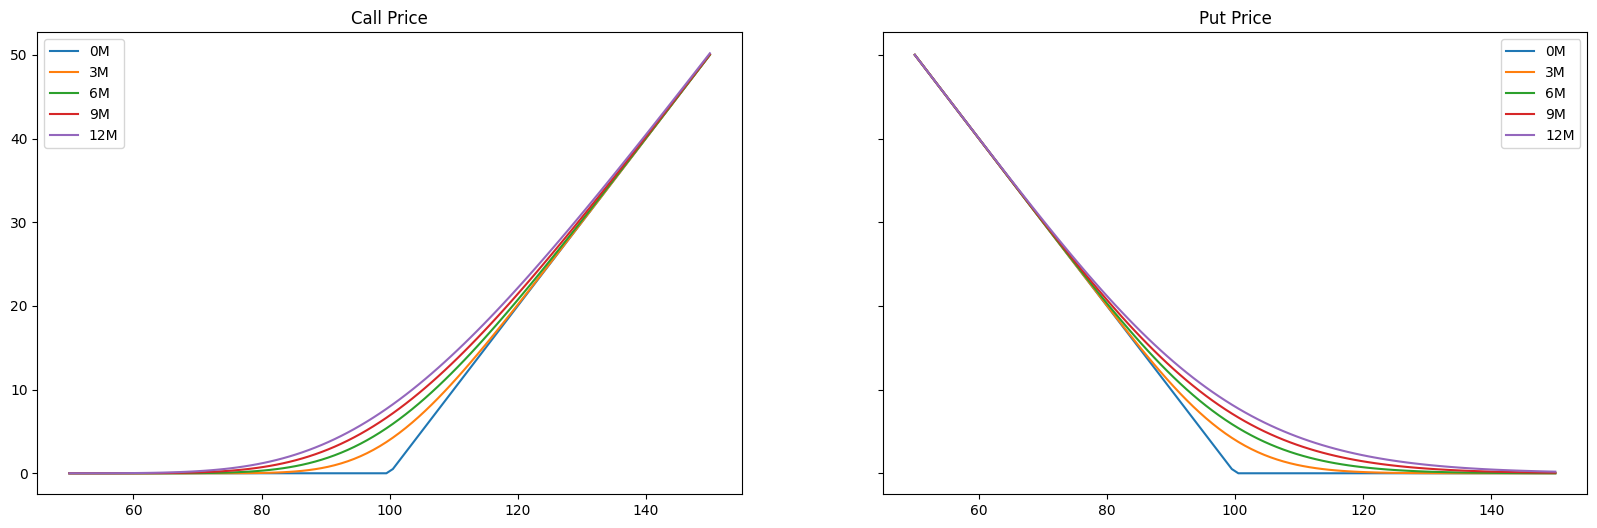

In [4]:
# Plot option values for range of spot prices over differece time
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Define expirations and labels
d = {'0M': 1e-50, '3M': 0.25, '6M': 0.5, '9M': 0.75, '12M': 1.0}
x = np.linspace(50, 150, 100)

# Plot call and put prices
for label, tau in d.items():
    bs = BS(x, 100, 0.0, tau, 0.2)
    axes[0].plot(x, bs.call_price, label=label)
    axes[1].plot(x, bs.put_price, label=label)

# Set titles and legends
for ax, title in zip(axes, ["Call Price", "Put Price"]):
    ax.set_title(title)
    ax.legend()

plt.show()

### Visualize the Greeks

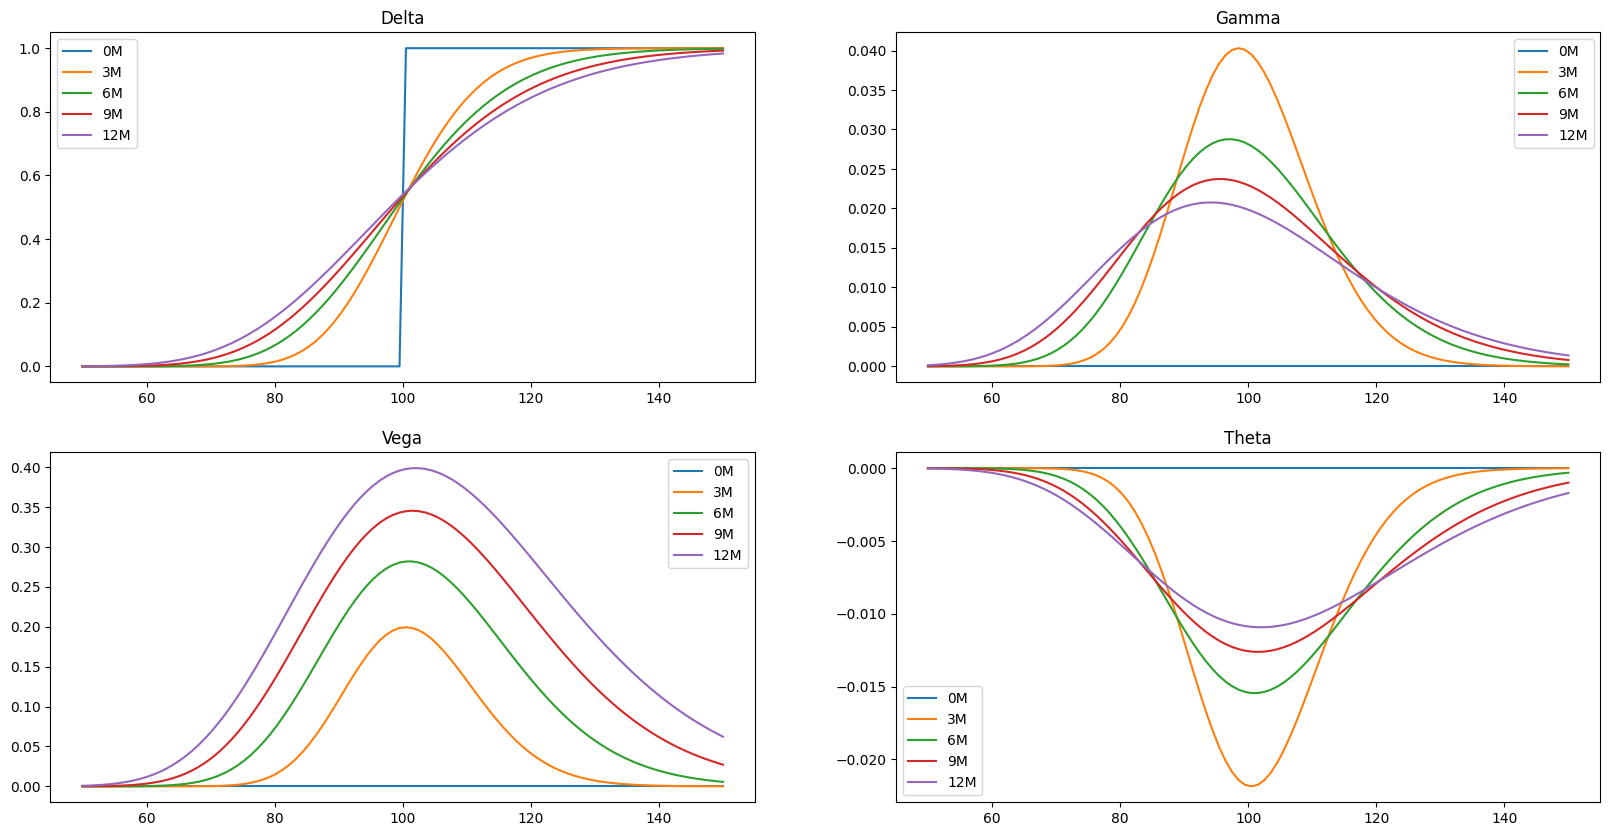

In [5]:
# Plot graph iteratively
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Define Greeks and their respective subplot positions
greeks = {
    (0, 0): ('call_delta', 'Delta'),
    (0, 1): ('gamma', 'Gamma'),
    (1, 0): ('vega', 'Vega'),
    (1, 1): ('call_theta', 'Theta')
}

# Plot all Greeks in one loop
for (i, j), (attr, title) in greeks.items():
    for label, tau in d.items():
        ax[i, j].plot(x, getattr(BS(x, 100, 0.0, tau, 0.2), attr), label=label)
    ax[i, j].set_title(title)
    ax[i, j].legend()

plt.show()


## Nifty Option

In [6]:
# update quantmod to version 0.0.6 for NSE options
from quantmod.derivatives import OptionData
from datetime import datetime, timedelta
from quantmod.models import OptionInputs, BlackScholesOptionPricing

In [7]:
# Get option chain for specify expiry
expiration = '27-Mar-2025'
valuation = datetime.today()
ttm = (pd.to_datetime(expiration+' 15:30:00') - pd.to_datetime(valuation)) / timedelta(days=365)

# Instantiate the Option Data
opt = OptionData("NIFTY", expiration)
df = opt.get_call_option_data
df.head(2)

,strikePrice,expiryDate,underlying,identifier,openInterest,changeinOpenInterest,pchangeinOpenInterest,totalTradedVolume,impliedVolatility,lastPrice,change,pChange,totalBuyQuantity,totalSellQuantity,bidQty,bidprice,askQty,askPrice,underlyingValue
0,18000,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE18000.00,6268.666667,-4.0,-0.063769,40,0.0,4431.05,-77.25,-1.713506,3900,4425,75,4413.75,75,4426.55,22397.2
1,19000,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE19000.00,1356.333333,-18.0,-1.309726,46,0.0,3432.15,-82.85,-2.357041,3975,5775,75,3419.05,75,3431.50,22397.2


In [8]:
df.shape

(122, 19)

In [9]:
df.head()

,strikePrice,expiryDate,underlying,identifier,openInterest,changeinOpenInterest,pchangeinOpenInterest,totalTradedVolume,impliedVolatility,lastPrice,change,pChange,totalBuyQuantity,totalSellQuantity,bidQty,bidprice,askQty,askPrice,underlyingValue
0,18000,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE18000.00,6268.666667,-4.0,-0.063769,40,0.0,4431.05,-77.25,-1.713506,3900,4425,75,4413.75,75,4426.55,22397.2
1,19000,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE19000.00,1356.333333,-18.0,-1.309726,46,0.0,3432.15,-82.85,-2.357041,3975,5775,75,3419.05,75,3431.50,22397.2
2,20000,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE20000.00,8037.666667,14.0,0.174484,584,0.0,2432.00,-90.30,-3.580066,4200,6750,225,2421.90,750,2432.00,22397.2
3,20350,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE20350.00,7.000000,0.0,0.000000,0,0.0,2296.75,0.00,0.000000,5475,5250,750,1865.90,1725,2247.10,22397.2
4,20400,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE20400.00,8.000000,0.0,0.000000,0,0.0,2197.85,0.00,0.000000,5250,6000,750,1825.70,750,2159.85,22397.2


In [10]:
# Dataframe manipulation with selected fields
df1 = pd.DataFrame({'Strike': df['strikePrice'],
                    'Price': df['lastPrice'],
                    })

# Instantiate BS Pricing Engine from quantmod and Derive Implied Volatiliy
for i in range(len(df1)):
    nifty = BlackScholesOptionPricing(
        OptionInputs(
            spot = 22400,
            strike = df1['Strike'].iloc[i], 
            rate = 0.0,
            ttm = ttm,
            volatility = 0.20,
            callprice = df1['Price'].iloc[i]
            )
        )
        
    df1.loc[i, 'ImpVol'] = nifty.impvol
    
# Check output
df1.head(10)

,Strike,Price,ImpVol
0,18000,4431.05,0.698757
1,19000,3432.15,0.554676
2,20000,2432.00,0.408466
3,20350,2296.75,0.644582
4,20400,2197.85,0.583518
5,20450,2150.00,0.575790
6,20500,1938.00,0.348698
7,20550,1909.65,0.380870
8,20600,2009.85,0.555642
9,20650,1894.80,0.476415


In [11]:
# Derive greeks and assign to dataframe as columns
for i in range(len(df1)):
    # initializing the BS option object
    nifty = BS(
        spot = 22400, 
        strike = df1['Strike'].iloc[i], 
        rate = 0.0,
        dte = ttm, 
        volatility=df1['ImpVol'].iloc[i]
        )
    # assign greeks to dataframe 
    df1.loc[i, 'Delta'] = nifty.call_delta
    df1.loc[i, 'Gamma'] = nifty.gamma
    df1.loc[i, 'Vega'] = nifty.vega
    df1.loc[i, 'Theta'] = nifty.call_theta
    
# Verify output
df1.head(10)

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,18000,4431.05,0.698757,0.971042,0.000025,2.521838,-8.314659
1,19000,3432.15,0.554676,0.963201,0.000038,3.072784,-8.042152
2,20000,2432.00,0.408466,0.951858,0.000064,3.819069,-7.360610
3,20350,2296.75,0.644582,0.823509,0.000105,9.891488,-30.084330
4,20400,2197.85,0.583518,0.839008,0.000110,9.324027,-25.671956
5,20450,2150.00,0.575790,0.835815,0.000113,9.443912,-25.657663
6,20500,1938.00,0.348698,0.935939,0.000094,4.784936,-7.872748
7,20550,1909.65,0.380870,0.913202,0.000109,6.032891,-10.841837
8,20600,2009.85,0.555642,0.824372,0.000122,9.860825,-25.852874
9,20650,1894.80,0.476415,0.851453,0.000127,8.841266,-19.874691


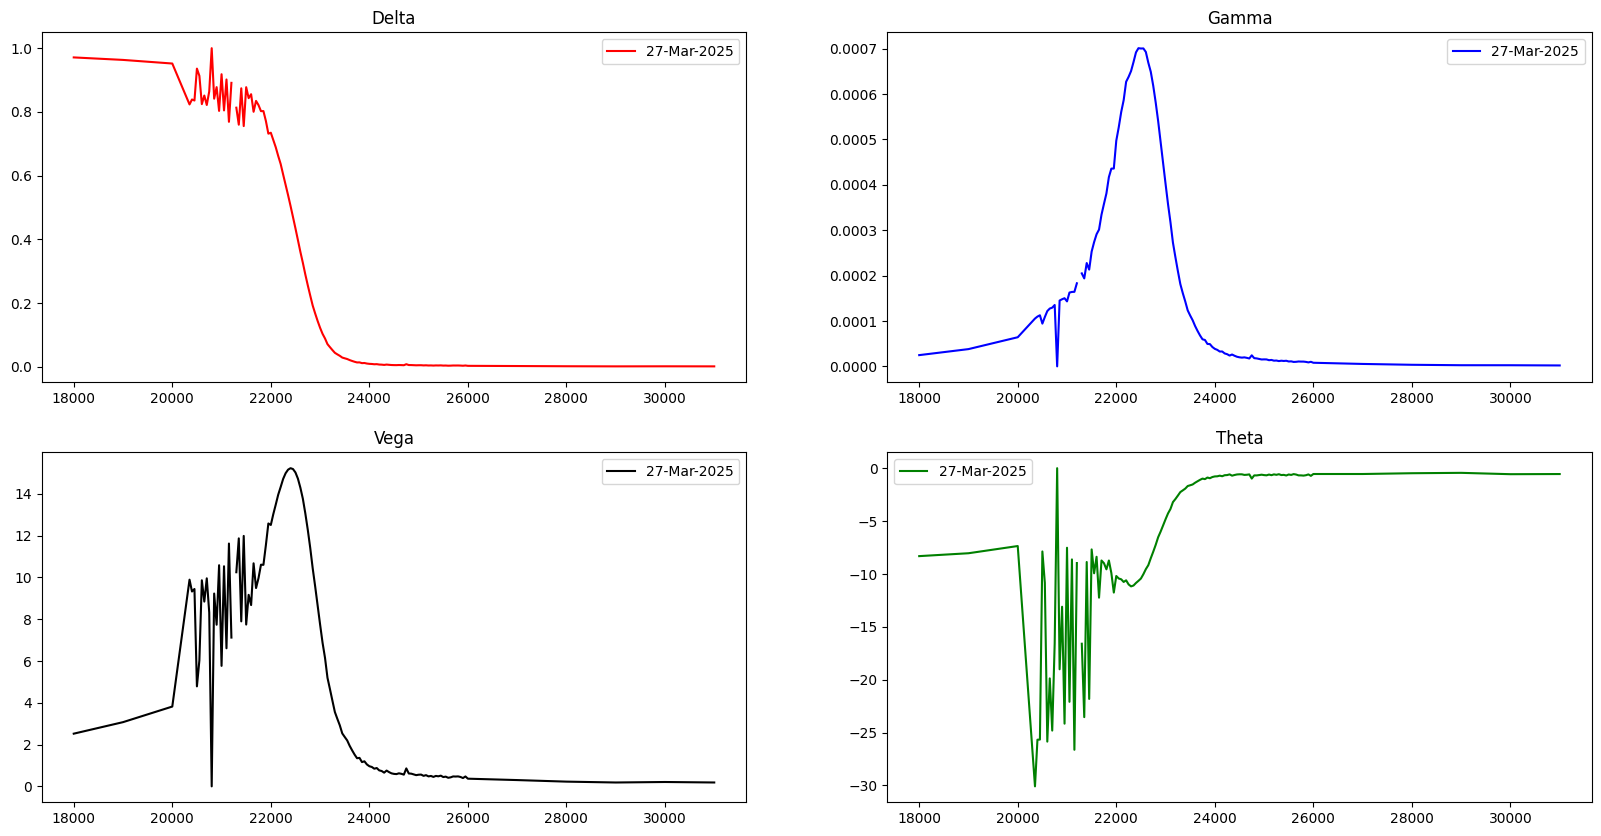

In [12]:
# Plot graph iteratively
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Greek parameters
greeks = {
    (0,0): ('Delta', 'r'),
    (0,1): ('Gamma', 'b'),
    (1,0): ('Vega', 'k'),
    (1,1): ('Theta', 'g')
}

# Plot all greeks in one loop
for (i,j), (greek, color) in greeks.items():
    axes[i,j].plot(df1['Strike'], df1[greek], color=color, label=expiration)
    axes[i,j].set_title(greek)
    axes[i,j].legend()

plt.show()